In [ ]:
# RESNET9 MODEL

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
project_name = 'resnet9_model'

In [ ]:
!gdown https://drive.google.com/uc?id=1Qc66kVqetwJIK7cKXnXxbPJy6gnpRSRI
!unzip The_Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'
pred_path = '/content/seg_pred'

In [ ]:
classes = os.listdir(train_path)
print(classes)

['buildings', 'forest', 'street', 'glacier', 'mountain', 'sea']


In [ ]:
## counting no of images in each class
images_per_class = []
for x in classes:
  num = len(os.listdir(train_path+'/'+x))
  print('No.of images in {} class is {}'.format(x,num))
  images_per_class.append(num)
print('\n')
print('no.of images in training folder: ',sum(images_per_class))

No.of images in buildings class is 2191
No.of images in forest class is 2271
No.of images in street class is 2382
No.of images in glacier class is 2404
No.of images in mountain class is 2512
No.of images in sea class is 2274


no.of images in training folder:  14034


In [ ]:
from torchvision.transforms import ToTensor
train_set = ImageFolder(train_path,transform = ToTensor())

In [ ]:
train_set

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: /content/seg_train/seg_train
    StandardTransform
Transform: ToTensor()

In [ ]:
def show_images(image,label):
  print('Label: {}, {}'.format(train_set.classes[label],label))
  plt.imshow(image.permute(1,2,0))

Label: buildings, 0


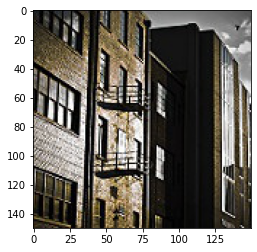

In [ ]:
show_images(*train_set[100])

In [ ]:
## checking if all images are in the same size (3x150x150)
num = 0
for image,label in train_set:
  if image.shape == (3,150,150):
    continue
  else:
    print(image.shape)
    num += 1
print('No.of images which are not in uniform shape: ',num)

torch.Size([3, 124, 150])
torch.Size([3, 113, 150])
torch.Size([3, 108, 150])
torch.Size([3, 133, 150])
torch.Size([3, 115, 150])
torch.Size([3, 135, 150])
torch.Size([3, 136, 150])
torch.Size([3, 108, 150])
torch.Size([3, 113, 150])
torch.Size([3, 110, 150])
torch.Size([3, 105, 150])
torch.Size([3, 111, 150])
torch.Size([3, 120, 150])
torch.Size([3, 149, 150])
torch.Size([3, 143, 150])
torch.Size([3, 146, 150])
torch.Size([3, 134, 150])
torch.Size([3, 142, 150])
torch.Size([3, 123, 150])
torch.Size([3, 119, 150])
torch.Size([3, 102, 150])
torch.Size([3, 76, 150])
torch.Size([3, 97, 150])
torch.Size([3, 111, 150])
torch.Size([3, 111, 150])
torch.Size([3, 135, 150])
torch.Size([3, 134, 150])
torch.Size([3, 135, 150])
torch.Size([3, 123, 150])
torch.Size([3, 113, 150])
torch.Size([3, 142, 150])
torch.Size([3, 144, 150])
torch.Size([3, 103, 150])
torch.Size([3, 136, 150])
torch.Size([3, 144, 150])
torch.Size([3, 100, 150])
torch.Size([3, 143, 150])
torch.Size([3, 141, 150])
torch.Size([3,

In [ ]:
# now on the training set we  first resize and perform different data augmnetation techniques

train_tfms = tt.Compose([tt.Resize((150,150)),
                         tt.RandomCrop(150,padding = 10,padding_mode = 'reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor()])
val_tfms = tt.Compose([tt.Resize((150,150)),
                       tt.ToTensor()])

In [ ]:
train_ds = ImageFolder(train_path,transform = train_tfms)
val_ds = ImageFolder(test_path,transform = val_tfms)

torch.Size([3, 150, 150])
Label: 0


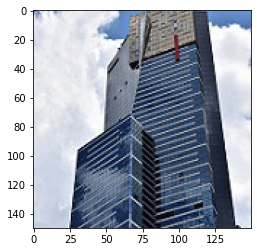

In [ ]:
for image,label in val_ds:
  print(image.shape)
  print('Label:',label)
  plt.imshow(image.permute(1,2,0))
  break

torch.Size([3, 150, 150])
Label: 0


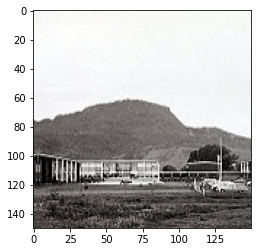

In [ ]:
for image,label in train_ds:
  print(image.shape)
  print('Label:',label)
  plt.imshow(image.permute(1,2,0))
  break

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds,batch_size,shuffle = True,num_workers = 2,pin_memory = True)
val_dl = DataLoader(val_ds,batch_size*2,num_workers = 2,pin_memory = True)

In [ ]:
# Defining function show_batch to show all images in one batch
def show_batch(dl):
  for images,labels in dl:
    fig,ax = plt.subplots(figsize = (16,8))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(images[:32],nrow = 8).permute(1,2,0).clamp(0,1))
    break

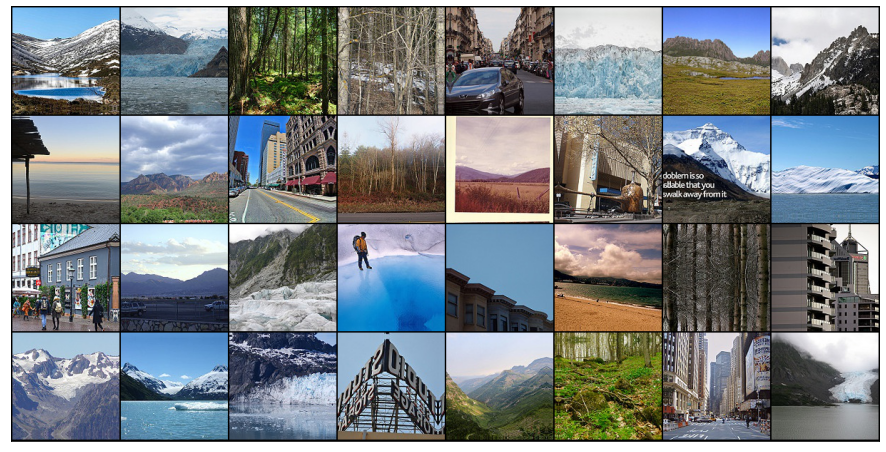

In [ ]:
show_batch(train_dl)

Label: buildings, 0


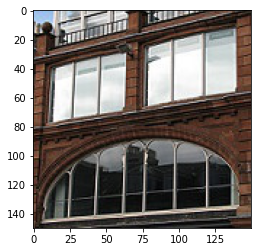

In [ ]:
show_images(*train_set[11])

Label: buildings, 0


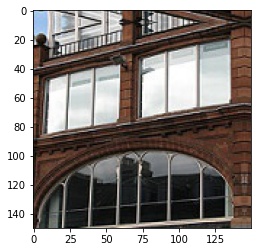

In [ ]:
show_images(*train_ds[11])

In [ ]:
## using a gpu
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data,device):
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking = True)

In [ ]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
  
  def __len__(self):
    return len(self.dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1,padding = 1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace = True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)          #64 x 150 x 150
        self.conv2 = conv_block(64, 128, pool=True)       # 128 x 75 x 75
        self.res1 = nn.Sequential(conv_block(128, 128), 
                                  conv_block(128, 128))   # 128 x 75 x 75
        
        self.conv3 = conv_block(128, 256, pool=True)     #256 x 37 x 37
        self.conv4 = conv_block(256, 512, pool=True)     # 512 x 18 x 18
        self.res2 = nn.Sequential(conv_block(512, 512),
                                  conv_block(512, 512))  # 512 x 18 x 18
        
        self.classifier = nn.Sequential(nn.MaxPool2d(18), # 512 x 1 x 1
                                        nn.Flatten(),     #512
                                        nn.Dropout(0.2),  
                                        nn.Linear(512, num_classes))  # 512--> 10
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3,6),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)       # Calculate loss
            train_losses.append(loss)
            loss.backward()           # Calulate gradients
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()    # Update parameters based on gradients
            optimizer.zero_grad() # empty gradients
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader) # calculate accuracy and loss
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)  
        history.append(result)
    return history

In [ ]:
history = [evaluate(model,val_dl)]

In [ ]:
history

[{'val_acc': 0.1569010466337204, 'val_loss': 1.792919397354126}]

In [ ]:
epochs=10
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
opt_func= torch.optim.Adam

In [ ]:
%%time

history+=fit_one_cycle(epochs,max_lr,model,train_dl,val_dl,
                       grad_clip=grad_clip,
                       weight_decay=weight_decay,
                       opt_func=opt_func)

Epoch [0], last_lr: 0.00279, train_loss: 0.9638, val_loss: 1.3858, val_acc: 0.5512
Epoch [1], last_lr: 0.00759, train_loss: 0.8363, val_loss: 1.3130, val_acc: 0.5485
Epoch [2], last_lr: 0.01000, train_loss: 0.8048, val_loss: 0.9316, val_acc: 0.6765
Epoch [3], last_lr: 0.00950, train_loss: 0.5976, val_loss: 0.8278, val_acc: 0.6911
Epoch [4], last_lr: 0.00812, train_loss: 0.4967, val_loss: 0.4730, val_acc: 0.8325
Epoch [5], last_lr: 0.00611, train_loss: 0.4551, val_loss: 0.3722, val_acc: 0.8672
Epoch [6], last_lr: 0.00389, train_loss: 0.3858, val_loss: 0.4466, val_acc: 0.8402
Epoch [7], last_lr: 0.00188, train_loss: 0.3450, val_loss: 0.3387, val_acc: 0.8785
Epoch [8], last_lr: 0.00050, train_loss: 0.2877, val_loss: 0.2832, val_acc: 0.9001
Epoch [9], last_lr: 0.00000, train_loss: 0.2443, val_loss: 0.2680, val_acc: 0.9029
CPU times: user 12min 45s, sys: 13min 44s, total: 26min 29s
Wall time: 26min 8s
